In [17]:
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image
from IPython import display

In [18]:
COLUMN_NAMES = ['frame','track id','type','truncated','occluded','alpha','bbox_left','bbox_top',
                'bbox_right','bbox_bottom','height','width','length','pos_x','pos_y','pos_z','rot_y']


   1    frame        Frame within the sequence where the object appearers
   1    track id     Unique tracking id of this object within this sequence
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries.
		     Truncation 2 indicates an ignored object (in particular
		     in the beginning or end of a track) introduced by manual
		     labeling.
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.

In [19]:
df = pd.read_csv('/deepsort/KITTI/Tracking/label_02/0000.txt', header=None, sep=' ')
df.columns = COLUMN_NAMES
df.head()

,frame,track id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
0,0,-1,DontCare,-1,-1,-10.000000,219.310000,188.490000,245.500000,218.560000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000
1,0,-1,DontCare,-1,-1,-10.000000,47.560000,195.280000,115.480000,221.480000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000
2,0,0,Van,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245


In [20]:
df.loc[df.type.isin(['Truck','Van','Tram']),'type'] = 'Car'
df = df[df.type.isin(['Car','Pedestrian','Cyclist'])]
df

,frame,track id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
2,0,0,Car,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
7,1,0,Car,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,153,10,Car,0,2,-1.818856,680.294919,177.511028,842.313244,284.070033,1.524000,1.728591,3.894227,2.353367,1.622590,12.436503,-1.637280
1085,153,11,Car,0,2,1.864481,245.920800,194.456182,394.817829,286.444967,1.444000,1.595116,3.791789,-5.458963,1.908188,13.979427,1.497916
1086,153,12,Pedestrian,1,0,0.826456,1185.199080,151.165841,1241.000000,348.552707,1.688000,0.800000,0.884000,5.739732,1.500532,6.279632,1.543272
1087,153,13,Car,0,0,1.773993,344.361560,188.772369,430.531955,248.482384,1.422414,1.512803,3.707634,-6.033258,1.888008,19.788795,1.481180


In [72]:
DETECTION_COLOR_DICT = {'Car':(255,255,0),'Pedestrian':(0,255,255),'Cyclist':(141,40,255)}

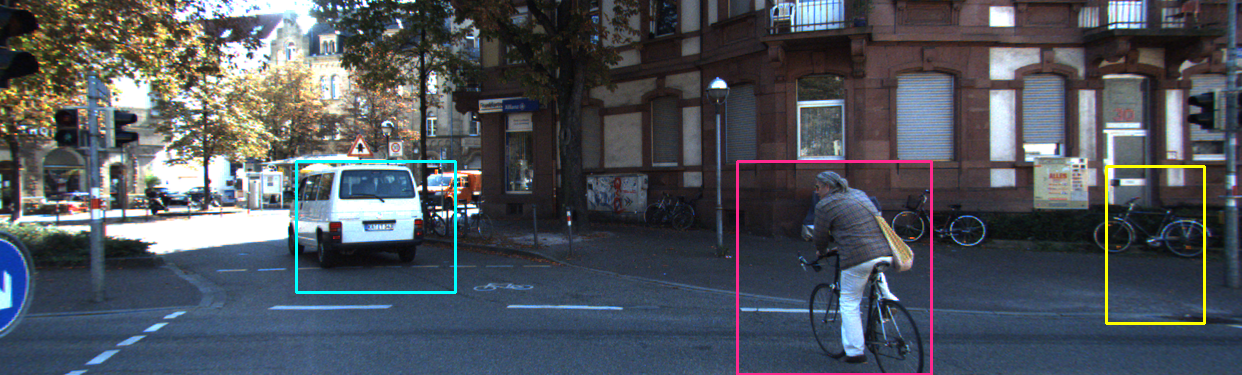

In [75]:
frame = 10

image = cv.imread('/deepsort/KITTI/RawData/2011_09_26/2011_09_26_drive_0005_sync/image_02/data/%010d.png'%frame)

boxes = np.array(df[df.frame == 0][['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']])
types = np.array(df[df.frame == 0]['type'])

for typ, box  in zip(types, boxes):
    t_l = int(box[0]),int(box[1])
    b_r = int(box[2]),int(box[3])
    cv.rectangle(image, t_l, b_r, DETECTION_COLOR_DICT[typ], 2)

image = Image.fromarray(cv.cvtColor(image,cv.COLOR_BGR2RGB))
image

array(['Car', 'Cyclist', 'Pedestrian'], dtype=object)

In [42]:
for typ, box  in zip(types, boxes):
    print(typ)
    print(box)

['Car']
[296.744956 161.752147 455.226042 292.372804]
['Cyclist']
[737.619499 161.531951 931.112229 374.      ]
['Pedestrian']
[1106.137292  166.576807 1204.470628  323.876144]
